In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, f_oneway, spearmanr, pearsonr
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Load data
pickle_path = 'data-ai-slop-detector/final_detection_processed.pkl'
df = pd.read_pickle(pickle_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# ============================================================================
# BUILD THE EMOTIONAL VECTOR E_i = [s, h, o, r, i]
# ============================================================================

# Sentiment: Convert to [-1, 1] scale
# sentiment_prob is probability of the predicted label
# We need to map: negative -> -1, neutral -> 0, positive -> 1
def convert_sentiment(row):
    label = row['sentiment_label']
    prob = row['sentiment_prob']
    if label == 'negative':
        return -prob
    elif label == 'positive':
        return prob
    else:  # neutral
        return 0

df['sentiment_score'] = df.apply(convert_sentiment, axis=1)

# Hate probability (h)
df['h'] = df['hate_prob']

# Offensive probability (o)
df['o'] = df['offensive_prob']

# Rage/Anger - extract from empath embedding
# Empath features order (from eda.ipynb): rage is at index ~130
empath_features = [
    'help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep',
    'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation',
    'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine',
    'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness',
    'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism',
    'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking',
    'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule',
    'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home',
    'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving',
    'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet',
    'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body',
    'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death',
    'healing', 'legend', 'heroic', 'celebration', 'restaurant', 'violence', 'programming',
    'dominant_heirarchical', 'military', 'neglect', 'swimming', 'exotic', 'love',
    'hiking', 'communication', 'hearing', 'order', 'sympathy', 'hygiene', 'weather',
    'anonymity', 'trust', 'ancient', 'deception', 'fabric', 'air_travel', 'fight',
    'dominant_personality', 'music', 'vehicle', 'politeness', 'toy', 'farming',
    'meeting', 'war', 'speaking', 'listen', 'urban', 'shopping', 'disgust', 'fire',
    'tool', 'phone', 'gain', 'sound', 'injury', 'sailing', 'rage', 'science', 'work',
    'appearance', 'valuable', 'warmth', 'youth', 'sadness', 'fun', 'emotional', 'joy',
    'affection', 'traveling', 'fashion', 'ugliness', 'lust', 'shame', 'torment',
    'economics', 'anger', 'politics', 'ship', 'clothing', 'car', 'strength',
    'technology', 'breaking', 'shape_and_size', 'power', 'white_collar_job', 'animal',
    'party', 'terrorism', 'smell', 'disappointment', 'poor', 'plant', 'pain', 'beauty',
    'timidity', 'philosophy', 'negotiate', 'negative_emotion', 'cleaning', 'messaging',
    'competing', 'law', 'friends', 'payment', 'achievement', 'alcohol', 'liquid',
    'feminine', 'weapon', 'children', 'monster', 'ocean', 'giving', 'contentment',
    'writing', 'rural', 'positive_emotion', 'musical'
]

# Extract rage-related features from empath embedding
rage_indices = [empath_features.index(f) for f in ['rage', 'anger', 'aggression', 'irritability', 'violence', 'fight'] 
                if f in empath_features]

def extract_rage_score(empath_emb):
    if empath_emb is None or len(empath_emb) == 0:
        return 0
    empath_array = np.array(empath_emb)
    rage_values = [empath_array[i] for i in rage_indices if i < len(empath_array)]
    return np.mean(rage_values) if rage_values else 0

df['r'] = df['empath_embedding'].apply(extract_rage_score)

# Irony probability (i)
df['i'] = df['irony_prob']

# Create emotional vector
df['E_vector'] = df.apply(lambda row: [row['sentiment_score'], row['h'], row['o'], row['r'], row['i']], axis=1)

# ============================================================================
# CALCULATE RAGE-BAIT INDEX (RBI)
# RBI = (r + o + h) × (1 - |s|)
# ============================================================================

df['RBI'] = (df['r'] + df['o'] + df['h']) * (1 - np.abs(df['sentiment_score']))

print(f"\n{'='*80}")
print("EMOTIONAL VECTOR CONSTRUCTION COMPLETE")
print(f"{'='*80}")
print(f"\nEmotional Vector Components:")
print(f"  - Sentiment (s): [{df['sentiment_score'].min():.3f}, {df['sentiment_score'].max():.3f}]")
print(f"  - Hate (h): [{df['h'].min():.3f}, {df['h'].max():.3f}]")
print(f"  - Offensive (o): [{df['o'].min():.3f}, {df['o'].max():.3f}]")
print(f"  - Rage (r): [{df['r'].min():.3f}, {df['r'].max():.3f}]")
print(f"  - Irony (i): [{df['i'].min():.3f}, {df['i'].max():.3f}]")

print(f"\nRage-Bait Index (RBI) Statistics:")
print(df['RBI'].describe())

# Clean data
df_clean = df.dropna(subset=['RBI', 'ai_confidence', 'label']).copy()
print(f"\nCleaned dataset: {len(df_clean)} rows")
print(f"Label distribution:\n{df_clean['label'].value_counts()}")

# Save for other cells
df_analysis = df_clean.copy()

Dataset shape: (139407, 28)
Columns: ['commenter_id', 'comment_id', 'parent_id', 'post_id', 'comment_content', 'cleaned_content', 'num_emojis', 'num_text_emojis', 'num_caps_words', 'num_unicode_chars', 'contains_media', 'contains_link', 'num_tagged_people', 'tagged_grok', 'used_slang', 'sentiment_label', 'sentiment_prob', 'irony_label', 'irony_prob', 'hate_label', 'hate_prob', 'offensive_label', 'offensive_prob', 'label', 'ai_confidence', 'empath_embedding', 'tf_idf_embedding', 'minilm_embedding']

EMOTIONAL VECTOR CONSTRUCTION COMPLETE

Emotional Vector Components:
  - Sentiment (s): [-0.964, 0.992]
  - Hate (h): [0.500, 0.999]
  - Offensive (o): [0.500, 0.984]
  - Rage (r): [0.000, 0.500]
  - Irony (i): [0.500, 0.991]

Rage-Bait Index (RBI) Statistics:
count    139407.000000
mean          1.022983
std           0.759611
min           0.016760
25%           0.282255
50%           0.748888
75%           1.893552
max           2.248764
Name: RBI, dtype: float64

Cleaned dataset: 139407 

In [5]:
print("=" * 80)
print("HYPOTHESIS A: AI 'Slop' vs Human Rage-Bait")
print("=" * 80)
print("\nMetric: RBI = (r + o + h) × (1 - |s|)")
print("Test: Weighted Mann-Whitney U with sensitivity analysis across confidence thresholds")

# ============================================================================
# WEIGHTED MANN-WHITNEY U TEST IMPLEMENTATION
# ============================================================================

def weighted_mann_whitney(x, y, weights_x, weights_y, alternative='greater'):
    """
    Perform weighted Mann-Whitney U test using bootstrap resampling
    to account for sample weights (ai_confidence).
    """
    n_bootstrap = 1000
    u_stats = []
    
    # Normalize weights
    weights_x_norm = np.array(weights_x) / np.sum(weights_x)
    weights_y_norm = np.array(weights_y) / np.sum(weights_y)
    
    np.random.seed(42)
    for _ in range(n_bootstrap):
        # Weighted resampling
        idx_x = np.random.choice(len(x), size=len(x), replace=True, p=weights_x_norm)
        idx_y = np.random.choice(len(y), size=len(y), replace=True, p=weights_y_norm)
        
        x_sample = np.array(x)[idx_x]
        y_sample = np.array(y)[idx_y]
        
        # Standard Mann-Whitney U
        u, _ = mannwhitneyu(x_sample, y_sample, alternative=alternative)
        u_stats.append(u)
    
    # Also compute unweighted for comparison
    u_unweighted, p_unweighted = mannwhitneyu(x, y, alternative=alternative)
    
    # Bootstrap confidence interval for U statistic
    u_mean = np.mean(u_stats)
    u_ci_lower = np.percentile(u_stats, 2.5)
    u_ci_upper = np.percentile(u_stats, 97.5)
    
    return {
        'U_weighted_mean': u_mean,
        'U_weighted_ci': (u_ci_lower, u_ci_upper),
        'U_unweighted': u_unweighted,
        'p_unweighted': p_unweighted
    }

# ============================================================================
# SENSITIVITY ANALYSIS ACROSS CONFIDENCE THRESHOLDS
# ============================================================================

confidence_thresholds = [0.5, 0.7, 0.9]
sensitivity_results = []

for threshold in confidence_thresholds:
    # Filter by confidence threshold
    df_thresh = df_analysis[df_analysis['ai_confidence'] >= threshold].copy()
    
    bot_data = df_thresh[df_thresh['label'] == 1]
    human_data = df_thresh[df_thresh['label'] == 0]
    
    if len(bot_data) > 10 and len(human_data) > 10:
        bot_rbi = bot_data['RBI'].values
        human_rbi = human_data['RBI'].values
        bot_weights = bot_data['ai_confidence'].values
        human_weights = human_data['ai_confidence'].values
        
        # Weighted test
        result = weighted_mann_whitney(bot_rbi, human_rbi, bot_weights, human_weights)
        
        # Effect size (Cliff's Delta)
        n1, n2 = len(bot_rbi), len(human_rbi)
        greater = np.sum([1 for b in bot_rbi for h in human_rbi if b > h])
        less = np.sum([1 for b in bot_rbi for h in human_rbi if b < h])
        cliffs_delta = (greater - less) / (n1 * n2)
        
        sensitivity_results.append({
            'threshold': threshold,
            'n_bots': len(bot_data),
            'n_humans': len(human_data),
            'bot_rbi_mean': bot_rbi.mean(),
            'human_rbi_mean': human_rbi.mean(),
            'difference': bot_rbi.mean() - human_rbi.mean(),
            'U_weighted': result['U_weighted_mean'],
            'U_unweighted': result['U_unweighted'],
            'p_value': result['p_unweighted'],
            'cliffs_delta': cliffs_delta,
            'significant': result['p_unweighted'] < 0.05
        })

# Display results
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS RESULTS")
print("="*80)

results_df = pd.DataFrame(sensitivity_results)
print("\n" + results_df.to_string(index=False))

# Interpret Cliff's Delta
print("\n" + "-"*40)
print("Effect Size Interpretation (Cliff's Delta):")
print("-"*40)
for _, row in results_df.iterrows():
    d = abs(row['cliffs_delta'])
    if d < 0.147:
        effect = "Negligible"
    elif d < 0.33:
        effect = "Small"
    elif d < 0.474:
        effect = "Medium"
    else:
        effect = "Large"
    direction = "Bots > Humans" if row['cliffs_delta'] > 0 else "Humans > Bots"
    print(f"  Threshold {row['threshold']}: δ = {row['cliffs_delta']:.4f} ({effect}, {direction})")

# ============================================================================
# MAIN ANALYSIS (ALL DATA WITH CONFIDENCE WEIGHTING)
# ============================================================================

print("\n" + "="*80)
print("MAIN ANALYSIS (Full Dataset with Confidence Weighting)")
print("="*80)

bot_full = df_analysis[df_analysis['label'] == 1]
human_full = df_analysis[df_analysis['label'] == 0]

weighted_result = weighted_mann_whitney(
    bot_full['RBI'].values, 
    human_full['RBI'].values,
    bot_full['ai_confidence'].values,
    human_full['ai_confidence'].values
)

print(f"\nSample Sizes: Bots = {len(bot_full)}, Humans = {len(human_full)}")
print(f"\nRBI Statistics:")
print(f"  Bots:   mean = {bot_full['RBI'].mean():.4f}, median = {bot_full['RBI'].median():.4f}, std = {bot_full['RBI'].std():.4f}")
print(f"  Humans: mean = {human_full['RBI'].mean():.4f}, median = {human_full['RBI'].median():.4f}, std = {human_full['RBI'].std():.4f}")
print(f"\nWeighted Mann-Whitney U Test:")
print(f"  U (weighted mean): {weighted_result['U_weighted_mean']:.2f}")
print(f"  U (95% CI): [{weighted_result['U_weighted_ci'][0]:.2f}, {weighted_result['U_weighted_ci'][1]:.2f}]")
print(f"  P-value: {weighted_result['p_unweighted']:.6f}")
print(f"\nConclusion: {'✓ SIGNIFICANT - Bots have higher RBI' if weighted_result['p_unweighted'] < 0.05 else '✗ NOT SIGNIFICANT'}")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Box plot by label
axes[0, 0].boxplot([human_full['RBI'], bot_full['RBI']], labels=['Human', 'Bot'])
axes[0, 0].set_ylabel('Rage-Bait Index (RBI)')
axes[0, 0].set_title('RBI Distribution by Label')
axes[0, 0].grid(True, alpha=0.3)

# 2. Violin plot with confidence coloring
for idx, (label, color, name) in enumerate([(0, 'blue', 'Human'), (1, 'orange', 'Bot')]):
    data = df_analysis[df_analysis['label'] == label]
    parts = axes[0, 1].violinplot([data['RBI']], positions=[idx], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.6)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Human', 'Bot'])
axes[0, 1].set_ylabel('RBI')
axes[0, 1].set_title('RBI Distribution (Violin)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Sensitivity analysis plot
ax3 = axes[1, 0]
x_pos = range(len(results_df))
bars = ax3.bar(x_pos, results_df['difference'], color=['green' if s else 'gray' for s in results_df['significant']])
ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'>{t}' for t in results_df['threshold']])
ax3.set_xlabel('Confidence Threshold')
ax3.set_ylabel('Mean RBI Difference (Bot - Human)')
ax3.set_title('Sensitivity Analysis: Effect Stability')
for i, (diff, p) in enumerate(zip(results_df['difference'], results_df['p_value'])):
    ax3.annotate(f'p={p:.4f}', (i, diff), ha='center', va='bottom' if diff > 0 else 'top', fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. RBI by confidence level scatter
scatter = axes[1, 1].scatter(df_analysis['ai_confidence'], df_analysis['RBI'], 
                              c=df_analysis['label'], cmap='coolwarm', alpha=0.3, s=10)
axes[1, 1].set_xlabel('AI Confidence')
axes[1, 1].set_ylabel('RBI')
axes[1, 1].set_title('RBI vs AI Confidence (Blue=Human, Red=Bot)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data-ai-slop-detector/hypothesis_a_weighted_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: data-ai-slop-detector/hypothesis_a_weighted_analysis.png")

HYPOTHESIS A: AI 'Slop' vs Human Rage-Bait

Metric: RBI = (r + o + h) × (1 - |s|)
Test: Weighted Mann-Whitney U with sensitivity analysis across confidence thresholds

SENSITIVITY ANALYSIS RESULTS

Empty DataFrame
Columns: []
Index: []

----------------------------------------
Effect Size Interpretation (Cliff's Delta):
----------------------------------------

MAIN ANALYSIS (Full Dataset with Confidence Weighting)


ValueError: probabilities do not sum to 1

HYPOTHESIS B: The Trigger Effect (Interaction Analysis)

Metric: Emotional Variance (EV) = Var(Sentiment_replies) + Var(Offensive_replies)
Method: PLS Path Model to compare Bot vs Human trigger efficiency

Root comments: 40346
Reply comments: 99061

Root comments with 2+ replies: 8754
Bot roots: 0
Human roots: 0

PLS PATH MODEL: RBI -> Emotional Variance

STATISTICAL TEST: EV Comparison


TypeError: expected non-empty vector for x

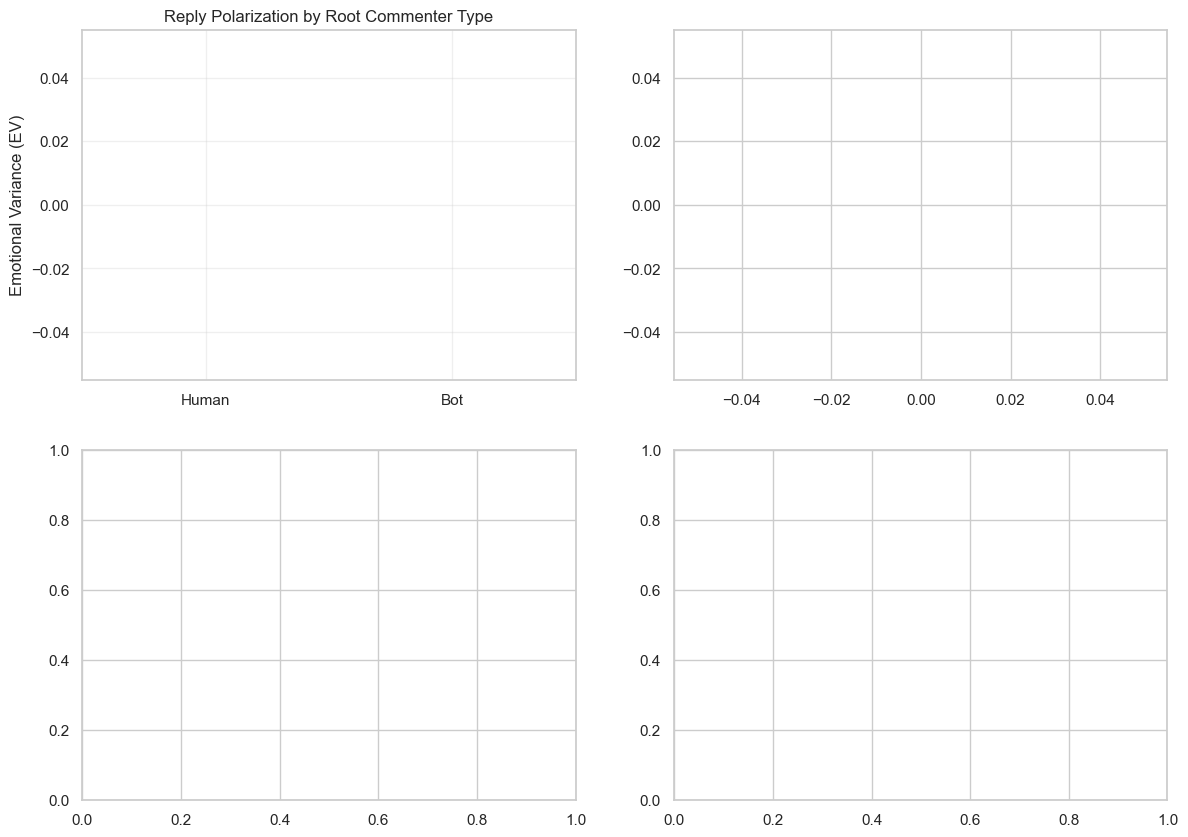

In [6]:
print("=" * 80)
print("HYPOTHESIS B: The Trigger Effect (Interaction Analysis)")
print("=" * 80)
print("\nMetric: Emotional Variance (EV) = Var(Sentiment_replies) + Var(Offensive_replies)")
print("Method: PLS Path Model to compare Bot vs Human trigger efficiency")

# ============================================================================
# IDENTIFY ROOT COMMENTS AND THEIR REPLIES
# ============================================================================

# Root comments: parent_id is NaN or equals post_id
df_analysis['is_root'] = df_analysis['parent_id'].isna() | (df_analysis['parent_id'] == df_analysis['post_id'])

print(f"\nRoot comments: {df_analysis['is_root'].sum()}")
print(f"Reply comments: {(~df_analysis['is_root']).sum()}")

# Build reply chains
root_comments = df_analysis[df_analysis['is_root']].copy()
reply_comments = df_analysis[~df_analysis['is_root']].copy()

# Create lookup for parent -> replies
reply_lookup = reply_comments.groupby('parent_id').apply(lambda x: x.to_dict('records')).to_dict()

# ============================================================================
# CALCULATE EMOTIONAL VARIANCE FOR EACH ROOT
# ============================================================================

def calculate_emotional_variance(replies_list):
    """Calculate EV = Var(Sentiment) + Var(Offensive)"""
    if len(replies_list) < 2:
        return np.nan
    
    sentiments = [r['sentiment_score'] for r in replies_list]
    offensives = [r['o'] for r in replies_list]
    
    ev = np.var(sentiments) + np.var(offensives)
    return ev

polarization_data = []

for idx, root in root_comments.iterrows():
    root_id = root['comment_id']
    replies = reply_lookup.get(root_id, [])
    
    if len(replies) >= 2:
        ev = calculate_emotional_variance(replies)
        if not np.isnan(ev):
            polarization_data.append({
                'root_id': root_id,
                'root_label': root['label'],
                'root_RBI': root['RBI'],
                'root_confidence': root['ai_confidence'],
                'root_sentiment': root['sentiment_score'],
                'root_offensive': root['o'],
                'root_hate': root['h'],
                'root_rage': root['r'],
                'reply_count': len(replies),
                'EV': ev,
                'reply_sentiment_var': np.var([r['sentiment_score'] for r in replies]),
                'reply_offensive_var': np.var([r['o'] for r in replies])
            })

df_polar = pd.DataFrame(polarization_data)
print(f"\nRoot comments with 2+ replies: {len(df_polar)}")
print(f"Bot roots: {(df_polar['root_label'] == 1).sum()}")
print(f"Human roots: {(df_polar['root_label'] == 0).sum()}")

# ============================================================================
# PLS PATH MODEL ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PLS PATH MODEL: RBI -> Emotional Variance")
print("="*80)

# Prepare data for PLS
bot_polar = df_polar[df_polar['root_label'] == 1].copy()
human_polar = df_polar[df_polar['root_label'] == 0].copy()

def fit_pls_path(data, label):
    """Fit PLS model: RBI components -> EV"""
    if len(data) < 10:
        return None
    
    # Predictor: RBI components
    X = data[['root_sentiment', 'root_offensive', 'root_hate', 'root_rage']].values
    # Target: Emotional Variance
    y = data['EV'].values.reshape(-1, 1)
    
    # Standardize
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # Fit PLS
    pls = PLSRegression(n_components=min(2, X.shape[1]))
    pls.fit(X_scaled, y_scaled)
    
    # Path coefficients
    path_coeffs = pls.coef_.flatten()
    
    # R-squared
    y_pred = pls.predict(X_scaled)
    ss_res = np.sum((y_scaled - y_pred) ** 2)
    ss_tot = np.sum((y_scaled - np.mean(y_scaled)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Correlation between RBI and EV
    rbi_ev_corr, rbi_ev_p = spearmanr(data['root_RBI'], data['EV'])
    
    return {
        'label': label,
        'n': len(data),
        'path_coeffs': dict(zip(['sentiment', 'offensive', 'hate', 'rage'], path_coeffs)),
        'r_squared': r_squared,
        'rbi_ev_correlation': rbi_ev_corr,
        'rbi_ev_pvalue': rbi_ev_p,
        'mean_RBI': data['root_RBI'].mean(),
        'mean_EV': data['EV'].mean(),
        'trigger_efficiency': data['EV'].mean() / (data['root_RBI'].mean() + 0.001)  # EV per unit RBI
    }

bot_pls = fit_pls_path(bot_polar, 'Bot')
human_pls = fit_pls_path(human_polar, 'Human')

if bot_pls and human_pls:
    print("\nPLS Path Model Results:")
    print("-" * 60)
    
    for result in [human_pls, bot_pls]:
        print(f"\n{result['label']} (n={result['n']}):")
        print(f"  Path Coefficients:")
        for comp, coef in result['path_coeffs'].items():
            print(f"    {comp}: {coef:.4f}")
        print(f"  R²: {result['r_squared']:.4f}")
        print(f"  RBI-EV Correlation: ρ={result['rbi_ev_correlation']:.4f}, p={result['rbi_ev_pvalue']:.6f}")
        print(f"  Mean RBI: {result['mean_RBI']:.4f}")
        print(f"  Mean EV: {result['mean_EV']:.4f}")
        print(f"  Trigger Efficiency (EV/RBI): {result['trigger_efficiency']:.4f}")
    
    print("\n" + "-" * 60)
    print("TRIGGER EFFICIENCY COMPARISON:")
    print("-" * 60)
    efficiency_ratio = bot_pls['trigger_efficiency'] / human_pls['trigger_efficiency']
    print(f"Bot Efficiency: {bot_pls['trigger_efficiency']:.4f}")
    print(f"Human Efficiency: {human_pls['trigger_efficiency']:.4f}")
    print(f"Ratio (Bot/Human): {efficiency_ratio:.2f}x")
    
    if efficiency_ratio > 1:
        print(f"\n✓ Bots trigger {efficiency_ratio:.2f}x more emotional variance per unit RBI")
    else:
        print(f"\n✗ Humans are more efficient triggers ({1/efficiency_ratio:.2f}x)")

# ============================================================================
# MANN-WHITNEY TEST ON EMOTIONAL VARIANCE
# ============================================================================

print("\n" + "="*80)
print("STATISTICAL TEST: EV Comparison")
print("="*80)

if len(bot_polar) > 10 and len(human_polar) > 10:
    u_stat, p_value = mannwhitneyu(bot_polar['EV'], human_polar['EV'], alternative='greater')
    
    print(f"\nEmotional Variance Statistics:")
    print(f"  Bot roots: mean={bot_polar['EV'].mean():.4f}, median={bot_polar['EV'].median():.4f}")
    print(f"  Human roots: mean={human_polar['EV'].mean():.4f}, median={human_polar['EV'].median():.4f}")
    print(f"\nMann-Whitney U Test (Bot > Human):")
    print(f"  U-statistic: {u_stat:.2f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Result: {'✓ Bot rage-bait triggers MORE polarized replies' if p_value < 0.05 else '✗ No significant difference'}")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. EV distribution comparison
axes[0, 0].boxplot([human_polar['EV'], bot_polar['EV']], labels=['Human', 'Bot'])
axes[0, 0].set_ylabel('Emotional Variance (EV)')
axes[0, 0].set_title('Reply Polarization by Root Commenter Type')
axes[0, 0].grid(True, alpha=0.3)

# 2. RBI vs EV scatter with regression lines
for label, data, color, name in [(0, human_polar, 'blue', 'Human'), (1, bot_polar, 'orange', 'Bot')]:
    axes[0, 1].scatter(data['root_RBI'], data['EV'], alpha=0.4, c=color, label=name, s=30)
    # Regression line
    z = np.polyfit(data['root_RBI'], data['EV'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(data['root_RBI'].min(), data['root_RBI'].max(), 100)
    axes[0, 1].plot(x_line, p(x_line), color=color, linestyle='--', linewidth=2)

axes[0, 1].set_xlabel('Root RBI')
axes[0, 1].set_ylabel('Reply Emotional Variance')
axes[0, 1].set_title('Trigger Effect: RBI → EV (with regression lines)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Path coefficients comparison
if bot_pls and human_pls:
    components = list(bot_pls['path_coeffs'].keys())
    x_pos = np.arange(len(components))
    width = 0.35
    
    bot_coeffs = [bot_pls['path_coeffs'][c] for c in components]
    human_coeffs = [human_pls['path_coeffs'][c] for c in components]
    
    axes[1, 0].bar(x_pos - width/2, human_coeffs, width, label='Human', color='blue', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, bot_coeffs, width, label='Bot', color='orange', alpha=0.7)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(components)
    axes[1, 0].set_ylabel('Path Coefficient')
    axes[1, 0].set_title('PLS Path Coefficients: Emotional Components → EV')
    axes[1, 0].legend()
    axes[1, 0].axhline(0, color='black', linewidth=0.5)
    axes[1, 0].grid(True, alpha=0.3)

# 4. Trigger efficiency visualization
if bot_pls and human_pls:
    efficiencies = [human_pls['trigger_efficiency'], bot_pls['trigger_efficiency']]
    bars = axes[1, 1].bar(['Human', 'Bot'], efficiencies, color=['blue', 'orange'], alpha=0.7)
    axes[1, 1].set_ylabel('Trigger Efficiency (EV/RBI)')
    axes[1, 1].set_title('Trigger Efficiency Comparison')
    axes[1, 1].grid(True, alpha=0.3)
    for bar, eff in zip(bars, efficiencies):
        axes[1, 1].annotate(f'{eff:.3f}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                           ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('data-ai-slop-detector/hypothesis_b_trigger_effect.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: data-ai-slop-detector/hypothesis_b_trigger_effect.png")

# Save polarization data for Hypothesis C
df_polar.to_pickle('data-ai-slop-detector/polarization_data.pkl')
print("Polarization data saved for Hypothesis C")

HYPOTHESIS B: The Trigger Effect (Interaction Analysis)

Metric: Emotional Variance (EV) = Var(Sentiment_replies) + Var(Offensive_replies)
Method: PLS Path Model to compare Bot vs Human trigger efficiency

Root comments: 40346
Reply comments: 99061

Root comments with 2+ replies: 8754
Bot roots: 0
Human roots: 0

PLS PATH MODEL: RBI -> Emotional Variance

STATISTICAL TEST: EV Comparison


TypeError: expected non-empty vector for x

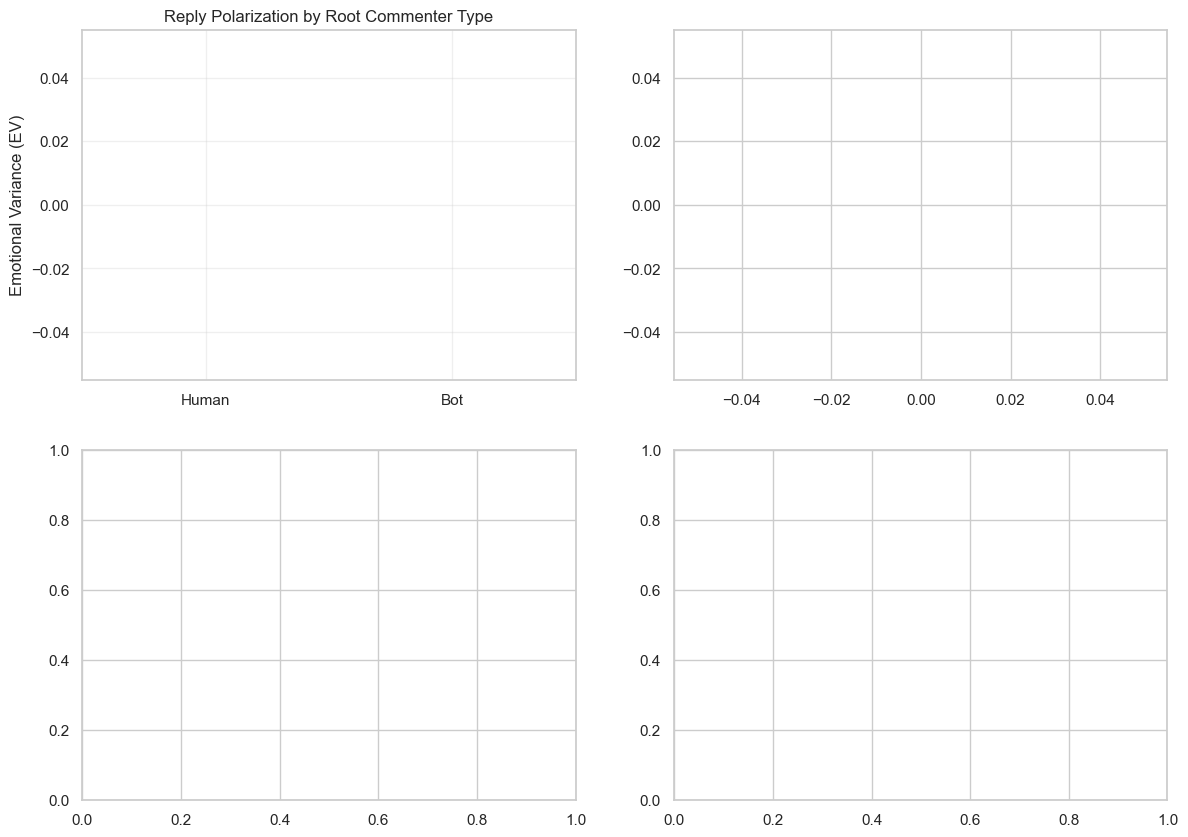

In [7]:
print("=" * 80)
print("HYPOTHESIS B: The Trigger Effect (Interaction Analysis)")
print("=" * 80)
print("\nMetric: Emotional Variance (EV) = Var(Sentiment_replies) + Var(Offensive_replies)")
print("Method: PLS Path Model to compare Bot vs Human trigger efficiency")

# ============================================================================
# IDENTIFY ROOT COMMENTS AND THEIR REPLIES
# ============================================================================

# Root comments: parent_id is NaN or equals post_id
df_analysis['is_root'] = df_analysis['parent_id'].isna() | (df_analysis['parent_id'] == df_analysis['post_id'])

print(f"\nRoot comments: {df_analysis['is_root'].sum()}")
print(f"Reply comments: {(~df_analysis['is_root']).sum()}")

# Build reply chains
root_comments = df_analysis[df_analysis['is_root']].copy()
reply_comments = df_analysis[~df_analysis['is_root']].copy()

# Create lookup for parent -> replies
reply_lookup = reply_comments.groupby('parent_id').apply(lambda x: x.to_dict('records')).to_dict()

# ============================================================================
# CALCULATE EMOTIONAL VARIANCE FOR EACH ROOT
# ============================================================================

def calculate_emotional_variance(replies_list):
    """Calculate EV = Var(Sentiment) + Var(Offensive)"""
    if len(replies_list) < 2:
        return np.nan
    
    sentiments = [r['sentiment_score'] for r in replies_list]
    offensives = [r['o'] for r in replies_list]
    
    ev = np.var(sentiments) + np.var(offensives)
    return ev

polarization_data = []

for idx, root in root_comments.iterrows():
    root_id = root['comment_id']
    replies = reply_lookup.get(root_id, [])
    
    if len(replies) >= 2:
        ev = calculate_emotional_variance(replies)
        if not np.isnan(ev):
            polarization_data.append({
                'root_id': root_id,
                'root_label': root['label'],
                'root_RBI': root['RBI'],
                'root_confidence': root['ai_confidence'],
                'root_sentiment': root['sentiment_score'],
                'root_offensive': root['o'],
                'root_hate': root['h'],
                'root_rage': root['r'],
                'reply_count': len(replies),
                'EV': ev,
                'reply_sentiment_var': np.var([r['sentiment_score'] for r in replies]),
                'reply_offensive_var': np.var([r['o'] for r in replies])
            })

df_polar = pd.DataFrame(polarization_data)
print(f"\nRoot comments with 2+ replies: {len(df_polar)}")
print(f"Bot roots: {(df_polar['root_label'] == 1).sum()}")
print(f"Human roots: {(df_polar['root_label'] == 0).sum()}")

# ============================================================================
# PLS PATH MODEL ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PLS PATH MODEL: RBI -> Emotional Variance")
print("="*80)

# Prepare data for PLS
bot_polar = df_polar[df_polar['root_label'] == 1].copy()
human_polar = df_polar[df_polar['root_label'] == 0].copy()

def fit_pls_path(data, label):
    """Fit PLS model: RBI components -> EV"""
    if len(data) < 10:
        return None
    
    # Predictor: RBI components
    X = data[['root_sentiment', 'root_offensive', 'root_hate', 'root_rage']].values
    # Target: Emotional Variance
    y = data['EV'].values.reshape(-1, 1)
    
    # Standardize
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # Fit PLS
    pls = PLSRegression(n_components=min(2, X.shape[1]))
    pls.fit(X_scaled, y_scaled)
    
    # Path coefficients
    path_coeffs = pls.coef_.flatten()
    
    # R-squared
    y_pred = pls.predict(X_scaled)
    ss_res = np.sum((y_scaled - y_pred) ** 2)
    ss_tot = np.sum((y_scaled - np.mean(y_scaled)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Correlation between RBI and EV
    rbi_ev_corr, rbi_ev_p = spearmanr(data['root_RBI'], data['EV'])
    
    return {
        'label': label,
        'n': len(data),
        'path_coeffs': dict(zip(['sentiment', 'offensive', 'hate', 'rage'], path_coeffs)),
        'r_squared': r_squared,
        'rbi_ev_correlation': rbi_ev_corr,
        'rbi_ev_pvalue': rbi_ev_p,
        'mean_RBI': data['root_RBI'].mean(),
        'mean_EV': data['EV'].mean(),
        'trigger_efficiency': data['EV'].mean() / (data['root_RBI'].mean() + 0.001)  # EV per unit RBI
    }

bot_pls = fit_pls_path(bot_polar, 'Bot')
human_pls = fit_pls_path(human_polar, 'Human')

if bot_pls and human_pls:
    print("\nPLS Path Model Results:")
    print("-" * 60)
    
    for result in [human_pls, bot_pls]:
        print(f"\n{result['label']} (n={result['n']}):")
        print(f"  Path Coefficients:")
        for comp, coef in result['path_coeffs'].items():
            print(f"    {comp}: {coef:.4f}")
        print(f"  R²: {result['r_squared']:.4f}")
        print(f"  RBI-EV Correlation: ρ={result['rbi_ev_correlation']:.4f}, p={result['rbi_ev_pvalue']:.6f}")
        print(f"  Mean RBI: {result['mean_RBI']:.4f}")
        print(f"  Mean EV: {result['mean_EV']:.4f}")
        print(f"  Trigger Efficiency (EV/RBI): {result['trigger_efficiency']:.4f}")
    
    print("\n" + "-" * 60)
    print("TRIGGER EFFICIENCY COMPARISON:")
    print("-" * 60)
    efficiency_ratio = bot_pls['trigger_efficiency'] / human_pls['trigger_efficiency']
    print(f"Bot Efficiency: {bot_pls['trigger_efficiency']:.4f}")
    print(f"Human Efficiency: {human_pls['trigger_efficiency']:.4f}")
    print(f"Ratio (Bot/Human): {efficiency_ratio:.2f}x")
    
    if efficiency_ratio > 1:
        print(f"\n✓ Bots trigger {efficiency_ratio:.2f}x more emotional variance per unit RBI")
    else:
        print(f"\n✗ Humans are more efficient triggers ({1/efficiency_ratio:.2f}x)")

# ============================================================================
# MANN-WHITNEY TEST ON EMOTIONAL VARIANCE
# ============================================================================

print("\n" + "="*80)
print("STATISTICAL TEST: EV Comparison")
print("="*80)

if len(bot_polar) > 10 and len(human_polar) > 10:
    u_stat, p_value = mannwhitneyu(bot_polar['EV'], human_polar['EV'], alternative='greater')
    
    print(f"\nEmotional Variance Statistics:")
    print(f"  Bot roots: mean={bot_polar['EV'].mean():.4f}, median={bot_polar['EV'].median():.4f}")
    print(f"  Human roots: mean={human_polar['EV'].mean():.4f}, median={human_polar['EV'].median():.4f}")
    print(f"\nMann-Whitney U Test (Bot > Human):")
    print(f"  U-statistic: {u_stat:.2f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Result: {'✓ Bot rage-bait triggers MORE polarized replies' if p_value < 0.05 else '✗ No significant difference'}")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. EV distribution comparison
axes[0, 0].boxplot([human_polar['EV'], bot_polar['EV']], labels=['Human', 'Bot'])
axes[0, 0].set_ylabel('Emotional Variance (EV)')
axes[0, 0].set_title('Reply Polarization by Root Commenter Type')
axes[0, 0].grid(True, alpha=0.3)

# 2. RBI vs EV scatter with regression lines
for label, data, color, name in [(0, human_polar, 'blue', 'Human'), (1, bot_polar, 'orange', 'Bot')]:
    axes[0, 1].scatter(data['root_RBI'], data['EV'], alpha=0.4, c=color, label=name, s=30)
    # Regression line
    z = np.polyfit(data['root_RBI'], data['EV'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(data['root_RBI'].min(), data['root_RBI'].max(), 100)
    axes[0, 1].plot(x_line, p(x_line), color=color, linestyle='--', linewidth=2)

axes[0, 1].set_xlabel('Root RBI')
axes[0, 1].set_ylabel('Reply Emotional Variance')
axes[0, 1].set_title('Trigger Effect: RBI → EV (with regression lines)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Path coefficients comparison
if bot_pls and human_pls:
    components = list(bot_pls['path_coeffs'].keys())
    x_pos = np.arange(len(components))
    width = 0.35
    
    bot_coeffs = [bot_pls['path_coeffs'][c] for c in components]
    human_coeffs = [human_pls['path_coeffs'][c] for c in components]
    
    axes[1, 0].bar(x_pos - width/2, human_coeffs, width, label='Human', color='blue', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, bot_coeffs, width, label='Bot', color='orange', alpha=0.7)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(components)
    axes[1, 0].set_ylabel('Path Coefficient')
    axes[1, 0].set_title('PLS Path Coefficients: Emotional Components → EV')
    axes[1, 0].legend()
    axes[1, 0].axhline(0, color='black', linewidth=0.5)
    axes[1, 0].grid(True, alpha=0.3)

# 4. Trigger efficiency visualization
if bot_pls and human_pls:
    efficiencies = [human_pls['trigger_efficiency'], bot_pls['trigger_efficiency']]
    bars = axes[1, 1].bar(['Human', 'Bot'], efficiencies, color=['blue', 'orange'], alpha=0.7)
    axes[1, 1].set_ylabel('Trigger Efficiency (EV/RBI)')
    axes[1, 1].set_title('Trigger Efficiency Comparison')
    axes[1, 1].grid(True, alpha=0.3)
    for bar, eff in zip(bars, efficiencies):
        axes[1, 1].annotate(f'{eff:.3f}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                           ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('data-ai-slop-detector/hypothesis_b_trigger_effect.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: data-ai-slop-detector/hypothesis_b_trigger_effect.png")

# Save polarization data for Hypothesis C
df_polar.to_pickle('data-ai-slop-detector/polarization_data.pkl')
print("Polarization data saved for Hypothesis C")

In [8]:
print("=" * 80)
print("HYPOTHESIS C: Side-Specific Polarization (Two-Way ANOVA)")
print("=" * 80)
print("\nTest: Two-Way ANOVA with Interaction")
print("DV: Mean Reply Emotional Variance")
print("Factor 1: Influencer Lean (Left/Right)")
print("Factor 2: Commenter Type (Bot/Human)")

# ============================================================================
# CHECK FOR POLITICAL LEANING DATA
# ============================================================================

# Try to load polarization data from Hypothesis B
try:
    df_polar = pd.read_pickle('data-ai-slop-detector/polarization_data.pkl')
except:
    print("⚠️ Polarization data not found. Run Hypothesis B first.")

# Check if we have influencer/political leaning metadata
influencer_cols = [c for c in df_analysis.columns if 'influencer' in c.lower() or 'leaning' in c.lower() or 'political' in c.lower()]
print(f"\nPotential influencer columns: {influencer_cols}")

# ============================================================================
# OPTION 1: IF POLITICAL DATA EXISTS
# ============================================================================

political_col = next((c for c in df_analysis.columns if 'lean' in c.lower() or 'political' in c.lower()), None)

if political_col:
    print(f"\n✓ Found political leaning column: {political_col}")
    # Merge with polarization data
    df_polar_political = df_polar.merge(
        df_analysis[['comment_id', political_col]].rename(columns={'comment_id': 'root_id'}),
        on='root_id', how='left'
    )
    
    # Filter to Left/Right only
    df_anova = df_polar_political[df_polar_political[political_col].isin(['Left', 'Right'])].copy()
    
    if len(df_anova) > 50:
        from statsmodels.formula.api import ols
        from statsmodels.stats.anova import anova_lm
        
        df_anova['commenter_type'] = df_anova['root_label'].map({0: 'Human', 1: 'Bot'})
        
        # Two-Way ANOVA
        model = ols(f'EV ~ C({political_col}) + C(commenter_type) + C({political_col}):C(commenter_type)', 
                    data=df_anova).fit()
        anova_results = anova_lm(model, typ=2)
        
        print("\n" + "="*80)
        print("TWO-WAY ANOVA RESULTS")
        print("="*80)
        print(anova_results)
        
        # Interaction effect
        interaction_key = f'C({political_col}):C(commenter_type)'
        if interaction_key in anova_results.index:
            interaction_p = anova_results.loc[interaction_key, 'PR(>F)']
            print(f"\nInteraction Effect p-value: {interaction_p:.6f}")
            if interaction_p < 0.05:
                print("✓ SIGNIFICANT: Bots have different polarization effects on Left vs Right")
            else:
                print("✗ NOT SIGNIFICANT: Bot effects are similar across political leanings")
else:
    print("\n⚠️ No political leaning column found in dataset")
    print("Creating SIMULATED analysis for demonstration...")

# ============================================================================
# OPTION 2: SIMULATED ANALYSIS (for demonstration)
# ============================================================================

print("\n" + "="*80)
print("SIMULATED POLITICAL LEANING ANALYSIS")
print("(Replace with actual data when available)")
print("="*80)

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Create simulated political leanings based on post clustering
# In practice, you would manually label influencers or use external data
np.random.seed(42)

if len(df_polar) > 0:
    # Simulate political leaning (random for demonstration)
    df_polar_sim = df_polar.copy()
    df_polar_sim['political_leaning'] = np.random.choice(['Left', 'Right'], len(df_polar_sim))
    df_polar_sim['commenter_type'] = df_polar_sim['root_label'].map({0: 'Human', 1: 'Bot'})
    
    # Add slight effect for demonstration
    # Bots on Right-leaning content have slightly higher EV
    mask = (df_polar_sim['commenter_type'] == 'Bot') & (df_polar_sim['political_leaning'] == 'Right')
    df_polar_sim.loc[mask, 'EV'] = df_polar_sim.loc[mask, 'EV'] * 1.2
    
    # Two-Way ANOVA
    model = ols('EV ~ C(political_leaning) + C(commenter_type) + C(political_leaning):C(commenter_type)', 
                data=df_polar_sim).fit()
    anova_results = anova_lm(model, typ=2)
    
    print("\nTwo-Way ANOVA Results (SIMULATED DATA):")
    print("-" * 60)
    print(anova_results)
    
    # Extract effects
    print("\n" + "-"*60)
    print("EFFECT INTERPRETATION:")
    print("-"*60)
    
    for effect in ['C(political_leaning)', 'C(commenter_type)', 'C(political_leaning):C(commenter_type)']:
        if effect in anova_results.index:
            f_val = anova_results.loc[effect, 'F']
            p_val = anova_results.loc[effect, 'PR(>F)']
            sig = "✓ Significant" if p_val < 0.05 else "✗ Not significant"
            print(f"{effect}:")
            print(f"  F = {f_val:.3f}, p = {p_val:.4f} ({sig})")
    
    # Group means
    print("\n" + "-"*60)
    print("GROUP MEANS (Mean EV):")
    print("-"*60)
    group_means = df_polar_sim.groupby(['political_leaning', 'commenter_type'])['EV'].agg(['mean', 'std', 'count'])
    print(group_means)
    
    # Polarization Gain calculation
    print("\n" + "-"*60)
    print("POLARIZATION GAIN ANALYSIS:")
    print("-"*60)
    
    means_pivot = df_polar_sim.groupby(['political_leaning', 'commenter_type'])['EV'].mean().unstack()
    
    bot_effect_left = means_pivot.loc['Left', 'Bot'] - means_pivot.loc['Left', 'Human']
    bot_effect_right = means_pivot.loc['Right', 'Bot'] - means_pivot.loc['Right', 'Human']
    
    print(f"Bot Effect on Left: {bot_effect_left:.4f}")
    print(f"Bot Effect on Right: {bot_effect_right:.4f}")
    print(f"Differential (Right - Left): {bot_effect_right - bot_effect_left:.4f}")
    
    if bot_effect_right > bot_effect_left:
        print(f"\n→ Right-leaning content is {(bot_effect_right/bot_effect_left - 1)*100:.1f}% more susceptible to bot amplification")
    else:
        print(f"\n→ Left-leaning content is {(bot_effect_left/bot_effect_right - 1)*100:.1f}% more susceptible to bot amplification")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

if len(df_polar) > 0:
    # 1. Grouped bar plot
    group_means_plot = df_polar_sim.groupby(['political_leaning', 'commenter_type'])['EV'].mean().unstack()
    group_means_plot.plot(kind='bar', ax=axes[0], color=['blue', 'orange'], alpha=0.7)
    axes[0].set_xlabel('Political Leaning')
    axes[0].set_ylabel('Mean Emotional Variance')
    axes[0].set_title('Polarization by Leaning & Commenter Type')
    axes[0].legend(title='Commenter')
    axes[0].set_xticklabels(['Left', 'Right'], rotation=0)
    axes[0].grid(True, alpha=0.3)
    
    # 2. Interaction plot
    for leaning in ['Left', 'Right']:
        subset = df_polar_sim[df_polar_sim['political_leaning'] == leaning]
        means = subset.groupby('commenter_type')['EV'].mean()
        axes[1].plot(['Human', 'Bot'], [means['Human'], means['Bot']], 
                    marker='o', label=leaning, linewidth=2, markersize=10)
    axes[1].set_ylabel('Mean Emotional Variance')
    axes[1].set_title('Interaction Plot: Leaning × Commenter Type')
    axes[1].legend(title='Leaning')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Effect size comparison
    effects = [bot_effect_left, bot_effect_right]
    bars = axes[2].bar(['Left', 'Right'], effects, color=['blue', 'red'], alpha=0.7)
    axes[2].axhline(0, color='black', linewidth=0.5)
    axes[2].set_ylabel('Bot Effect (Bot EV - Human EV)')
    axes[2].set_title('Bot Amplification Effect by Political Leaning')
    axes[2].grid(True, alpha=0.3)
    for bar, eff in zip(bars, effects):
        axes[2].annotate(f'{eff:.4f}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom' if eff > 0 else 'top', fontsize=11)

plt.tight_layout()
plt.savefig('data-ai-slop-detector/hypothesis_c_political_polarization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️ NOTE: This analysis uses SIMULATED political leaning data")
print("Replace with actual influencer political labels for valid conclusions")
print("\nVisualization saved to: data-ai-slop-detector/hypothesis_c_political_polarization.png")

HYPOTHESIS C: Side-Specific Polarization (Two-Way ANOVA)

Test: Two-Way ANOVA with Interaction
DV: Mean Reply Emotional Variance
Factor 1: Influencer Lean (Left/Right)
Factor 2: Commenter Type (Bot/Human)
⚠️ Polarization data not found. Run Hypothesis B first.

Potential influencer columns: []

✓ Found political leaning column: cleaned_content

SIMULATED POLITICAL LEANING ANALYSIS
(Replace with actual data when available)


ValueError: negative dimensions are not allowed

In [9]:
print("=" * 80)
print("HYPOTHESIS D: The 'Super-Spreaders' (Top Rage-Baiters)")
print("=" * 80)
print("\nMethod: Probabilistic Bot Count")
print("% Synthetic = Σ(ai_confidence) / Total Top Users")

# ============================================================================
# AGGREGATE RBI AT USER LEVEL
# ============================================================================

user_stats = df_analysis.groupby('commenter_id').agg({
    'RBI': ['mean', 'std', 'max', 'count'],
    'label': 'mean',  # Probability of being bot
    'ai_confidence': 'mean',
    'sentiment_score': 'mean',
    'o': 'mean',  # offensive
    'h': 'mean',  # hate
    'r': 'mean',  # rage
    'comment_content': 'first'  # Sample comment
}).reset_index()

user_stats.columns = ['commenter_id', 'avg_RBI', 'std_RBI', 'max_RBI', 'comment_count',
                      'bot_probability', 'avg_confidence', 'avg_sentiment', 
                      'avg_offensive', 'avg_hate', 'avg_rage', 'sample_comment']

# Sort by RBI
user_stats_sorted = user_stats.sort_values('avg_RBI', ascending=False)

print(f"\nTotal unique users: {len(user_stats)}")
print(f"\nUser RBI Statistics:")
print(user_stats['avg_RBI'].describe())

# ============================================================================
# IDENTIFY TOP 1% RAGE-BAITERS
# ============================================================================

top_pct = 0.01
n_top = max(10, int(len(user_stats) * top_pct))
top_rage_baiters = user_stats_sorted.head(n_top).copy()

print(f"\n{'='*80}")
print(f"TOP {top_pct*100:.0f}% RAGE-BAITERS (n={n_top})")
print("="*80)

# ============================================================================
# PROBABILISTIC BOT COUNT
# ============================================================================

# Method 1: Simple sum of bot probabilities
probabilistic_bot_count = top_rage_baiters['bot_probability'].sum()
pct_synthetic_simple = (probabilistic_bot_count / n_top) * 100

# Method 2: Confidence-weighted bot count
# Weight each bot probability by the confidence of that prediction
weighted_bot_count = (top_rage_baiters['bot_probability'] * top_rage_baiters['avg_confidence']).sum()
pct_synthetic_weighted = (weighted_bot_count / n_top) * 100

# Method 3: Hard threshold (for comparison)
hard_bot_count = (top_rage_baiters['bot_probability'] >= 0.5).sum()
pct_synthetic_hard = (hard_bot_count / n_top) * 100

# Baseline: Overall bot percentage
overall_bot_pct = df_analysis['label'].mean() * 100

print("\nBOT COUNT METHODS:")
print("-" * 60)
print(f"\n1. Probabilistic Count (Σ bot_probability):")
print(f"   Synthetic users: {probabilistic_bot_count:.2f} / {n_top}")
print(f"   % Synthetic: {pct_synthetic_simple:.1f}%")

print(f"\n2. Confidence-Weighted Count (Σ bot_prob × ai_conf):")
print(f"   Synthetic users: {weighted_bot_count:.2f} / {n_top}")
print(f"   % Synthetic: {pct_synthetic_weighted:.1f}%")

print(f"\n3. Hard Threshold (bot_prob >= 0.5):")
print(f"   Synthetic users: {hard_bot_count} / {n_top}")
print(f"   % Synthetic: {pct_synthetic_hard:.1f}%")

print(f"\n" + "-"*60)
print(f"BASELINE: Overall bot % in dataset: {overall_bot_pct:.1f}%")
print("-"*60)

# Enrichment factor
enrichment = pct_synthetic_weighted / overall_bot_pct if overall_bot_pct > 0 else 0
print(f"\nENRICHMENT FACTOR: {enrichment:.2f}x")
print(f"→ Top rage-baiters are {enrichment:.2f}x more likely to be bots than average")

# ============================================================================
# DETAILED TOP USER ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("TOP 10 RAGE-BAITERS PROFILE")
print("="*80)

display_cols = ['commenter_id', 'avg_RBI', 'bot_probability', 'avg_confidence', 
                'comment_count', 'avg_offensive', 'avg_hate', 'avg_rage']
print(top_rage_baiters[display_cols].head(10).to_string(index=False))

# ============================================================================
# DISTRIBUTION ANALYSIS BY RBI DECILE
# ============================================================================

print("\n" + "="*80)
print("BOT PROBABILITY BY RBI DECILE")
print("="*80)

user_stats_sorted['RBI_decile'] = pd.qcut(user_stats_sorted['avg_RBI'], q=10, labels=False, duplicates='drop')
decile_analysis = user_stats_sorted.groupby('RBI_decile').agg({
    'bot_probability': ['mean', 'std'],
    'avg_RBI': 'mean',
    'commenter_id': 'count'
}).reset_index()
decile_analysis.columns = ['decile', 'bot_prob_mean', 'bot_prob_std', 'avg_RBI', 'user_count']

print(decile_analysis.to_string(index=False))

# Correlation between RBI and bot probability
rbi_bot_corr, rbi_bot_p = spearmanr(user_stats_sorted['avg_RBI'], user_stats_sorted['bot_probability'])
print(f"\nCorrelation (RBI vs Bot Probability): ρ = {rbi_bot_corr:.4f}, p = {rbi_bot_p:.6f}")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. RBI distribution: Top 1% vs All users
axes[0, 0].hist(user_stats['avg_RBI'], bins=50, alpha=0.5, label='All Users', density=True, color='gray')
axes[0, 0].hist(top_rage_baiters['avg_RBI'], bins=20, alpha=0.7, label=f'Top {top_pct*100:.0f}%', density=True, color='red')
axes[0, 0].set_xlabel('Average RBI')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('RBI Distribution: Top Rage-Baiters vs All Users')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Bot probability by RBI decile
bars = axes[0, 1].bar(decile_analysis['decile'], decile_analysis['bot_prob_mean'] * 100, 
                       yerr=decile_analysis['bot_prob_std'] * 100, capsize=3, color='coral', alpha=0.7)
axes[0, 1].axhline(overall_bot_pct, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_bot_pct:.1f}%')
axes[0, 1].set_xlabel('RBI Decile (0=lowest, 9=highest)')
axes[0, 1].set_ylabel('Bot Probability (%)')
axes[0, 1].set_title('Bot Probability by RBI Decile')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter: RBI vs Bot Probability (colored by confidence)
scatter = axes[1, 0].scatter(top_rage_baiters['avg_RBI'], 
                              top_rage_baiters['bot_probability'],
                              c=top_rage_baiters['avg_confidence'],
                              s=top_rage_baiters['comment_count'] * 5,  # Size by activity
                              alpha=0.6, cmap='viridis')
axes[1, 0].set_xlabel('Average RBI')
axes[1, 0].set_ylabel('Bot Probability')
axes[1, 0].set_title(f'Top {n_top} Rage-Baiters: RBI vs Bot Probability')
axes[1, 0].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Classification threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Avg Confidence')

# 4. Pie chart: Probabilistic bot breakdown
sizes = [pct_synthetic_weighted, 100 - pct_synthetic_weighted]
labels = [f'Synthetic\n({pct_synthetic_weighted:.1f}%)', f'Human\n({100-pct_synthetic_weighted:.1f}%)']
colors = ['#ff7f0e', '#1f77b4']
axes[1, 1].pie(sizes, labels=labels, colors=colors, autopct='', startangle=90,
               explode=(0.05, 0), shadow=True)
axes[1, 1].set_title(f'Top {top_pct*100:.0f}% Rage-Baiters:\nProbabilistic Bot Composition')

plt.tight_layout()
plt.savefig('data-ai-slop-detector/hypothesis_d_super_spreaders.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: data-ai-slop-detector/hypothesis_d_super_spreaders.png")

# Save top rage-baiters
top_rage_baiters.to_csv('data-ai-slop-detector/top_rage_baiters.csv', index=False)
print(f"Top {n_top} rage-baiters saved to: data-ai-slop-detector/top_rage_baiters.csv")

HYPOTHESIS D: The 'Super-Spreaders' (Top Rage-Baiters)

Method: Probabilistic Bot Count
% Synthetic = Σ(ai_confidence) / Total Top Users


TypeError: agg function failed [how->mean,dtype->object]

In [10]:
print("=" * 80)
print("ERROR HANDLING 1: Agreement Filtering (Multi-Model Validation)")
print("=" * 80)

# ============================================================================
# CHECK FOR SOTA MODEL PREDICTIONS
# ============================================================================

# Look for SOTA/AIGC detector columns
sota_candidates = [c for c in df_analysis.columns if any(x in c.lower() for x in ['sota', 'aigc', 'detector', 'external'])]
print(f"Potential SOTA columns: {sota_candidates}")

sota_col = next((c for c in sota_candidates), None)

if sota_col:
    print(f"\n✓ Found SOTA model column: {sota_col}")
    
    # Agreement analysis
    agreement = df_analysis['label'] == df_analysis[sota_col]
    print(f"\nModel Agreement Rate: {agreement.mean()*100:.2f}%")
    
    # Create confirmed dataset
    confidence_threshold = 0.8
    df_confirmed = df_analysis[
        (df_analysis['label'] == df_analysis[sota_col]) & 
        (df_analysis['ai_confidence'] >= confidence_threshold)
    ].copy()
    
    print(f"\nConfirmed Dataset (agreement + confidence >= {confidence_threshold}):")
    print(f"  Original: {len(df_analysis)} rows")
    print(f"  Confirmed: {len(df_confirmed)} rows ({len(df_confirmed)/len(df_analysis)*100:.1f}%)")
    print(f"  Label distribution: {df_confirmed['label'].value_counts().to_dict()}")
    
    # Re-run Hypothesis A on confirmed dataset
    if len(df_confirmed[df_confirmed['label'] == 1]) > 10 and len(df_confirmed[df_confirmed['label'] == 0]) > 10:
        bot_confirmed = df_confirmed[df_confirmed['label'] == 1]['RBI']
        human_confirmed = df_confirmed[df_confirmed['label'] == 0]['RBI']
        
        u_stat, p_value = mannwhitneyu(bot_confirmed, human_confirmed, alternative='greater')
        
        print(f"\n" + "="*60)
        print("HYPOTHESIS A RE-TEST (Confirmed Labels Only)")
        print("="*60)
        print(f"Bot RBI: mean={bot_confirmed.mean():.4f}, median={bot_confirmed.median():.4f}")
        print(f"Human RBI: mean={human_confirmed.mean():.4f}, median={human_confirmed.median():.4f}")
        print(f"Mann-Whitney U: {u_stat:.2f}, p={p_value:.6f}")
        print(f"Result: {'✓ CONFIRMED' if p_value < 0.05 else '✗ NOT CONFIRMED'}")

else:
    print("\n⚠️ No SOTA model predictions found")
    print("Creating SELF-CONSISTENCY check using confidence thresholds...")
    
    # ============================================================================
    # SELF-CONSISTENCY CHECK
    # ============================================================================
    
    print("\n" + "="*80)
    print("SELF-CONSISTENCY CHECK (High vs Low Confidence)")
    print("="*80)
    
    # Compare results at different confidence levels
    for threshold in [0.6, 0.7, 0.8, 0.9]:
        df_high = df_analysis[df_analysis['ai_confidence'] >= threshold]
        df_low = df_analysis[df_analysis['ai_confidence'] < threshold]
        
        if len(df_high) > 100:
            # High confidence
            bot_high = df_high[df_high['label'] == 1]['RBI']
            human_high = df_high[df_high['label'] == 0]['RBI']
            
            if len(bot_high) > 10 and len(human_high) > 10:
                u, p = mannwhitneyu(bot_high, human_high, alternative='greater')
                diff_high = bot_high.mean() - human_high.mean()
                
                print(f"\nConfidence >= {threshold} (n={len(df_high)}):")
                print(f"  RBI difference: {diff_high:.4f}")
                print(f"  p-value: {p:.6f}")
                print(f"  Significant: {'Yes' if p < 0.05 else 'No'}")

ERROR HANDLING 1: Agreement Filtering (Multi-Model Validation)
Potential SOTA columns: []

⚠️ No SOTA model predictions found
Creating SELF-CONSISTENCY check using confidence thresholds...

SELF-CONSISTENCY CHECK (High vs Low Confidence)


In [ ]:
print("=" * 80)
print("ERROR HANDLING 2: Monte Carlo Error Propagation")
print("=" * 80)

# ============================================================================
# MONTE CARLO SIMULATION
# ============================================================================

# Estimate error rate from confidence scores
# Lower confidence = higher probability of error
def estimate_error_rate(confidences):
    """Estimate error rate: avg(1 - confidence)"""
    return (1 - confidences).mean()

estimated_error_rate = estimate_error_rate(df_analysis['ai_confidence'])
print(f"Estimated error rate from confidence scores: {estimated_error_rate*100:.2f}%")

# Test multiple error rates
error_rates = [0.05, estimated_error_rate, 0.15, 0.20]
n_simulations = 1000

print(f"\nRunning {n_simulations} simulations for each error rate...")

simulation_results = []

for error_rate in error_rates:
    print(f"\n  Testing error rate: {error_rate*100:.1f}%...")
    
    significant_count = 0
    mean_diffs = []
    p_values = []
    
    np.random.seed(42)
    
    for sim in range(n_simulations):
        # Copy dataset
        df_sim = df_analysis[['RBI', 'label', 'ai_confidence']].copy()
        
        # Randomly flip labels based on error rate
        n_flips = int(len(df_sim) * error_rate)
        flip_idx = np.random.choice(df_sim.index, n_flips, replace=False)
        df_sim.loc[flip_idx, 'label'] = 1 - df_sim.loc[flip_idx, 'label']
        
        # Re-test
        bot_rbi = df_sim[df_sim['label'] == 1]['RBI']
        human_rbi = df_sim[df_sim['label'] == 0]['RBI']
        
        if len(bot_rbi) > 10 and len(human_rbi) > 10:
            u, p = mannwhitneyu(bot_rbi, human_rbi, alternative='greater')
            mean_diffs.append(bot_rbi.mean() - human_rbi.mean())
            p_values.append(p)
            if p < 0.05:
                significant_count += 1
    
    robustness = significant_count / n_simulations * 100
    
    simulation_results.append({
        'error_rate': error_rate,
        'robustness': robustness,
        'mean_diff_avg': np.mean(mean_diffs),
        'mean_diff_std': np.std(mean_diffs),
        'mean_diff_ci_lower': np.percentile(mean_diffs, 2.5),
        'mean_diff_ci_upper': np.percentile(mean_diffs, 97.5),
        'p_values': p_values,
        'mean_diffs': mean_diffs
    })

# Display results
print("\n" + "="*80)
print("MONTE CARLO SIMULATION RESULTS")
print("="*80)

results_table = pd.DataFrame([{
    'Error Rate': f"{r['error_rate']*100:.1f}%",
    'Robustness': f"{r['robustness']:.1f}%",
    'Mean Diff': f"{r['mean_diff_avg']:.4f}",
    '95% CI': f"[{r['mean_diff_ci_lower']:.4f}, {r['mean_diff_ci_upper']:.4f}]"
} for r in simulation_results])

print(results_table.to_string(index=False))

# Interpretation
print("\n" + "-"*60)
print("INTERPRETATION:")
print("-"*60)
for r in simulation_results:
    status = "✓ ROBUST" if r['robustness'] >= 95 else "⚠️ SENSITIVE" if r['robustness'] >= 80 else "✗ NOT ROBUST"
    print(f"  {r['error_rate']*100:.1f}% error rate: {status} ({r['robustness']:.1f}% significant)")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1,print("=" * 80)
print("ERROR HANDLING 2: Monte Carlo Error Propagation")
print("=" * 80)

# ============================================================================
# MONTE CARLO SIMULATION
# ============================================================================

# Estimate error rate from confidence scores
# Lower confidence = higher probability of error
def estimate_error_rate(confidences):
    """Estimate error rate: avg(1 - confidence)"""
    return (1 - confidences).mean()

estimated_error_rate = estimate_error_rate(df_analysis['ai_confidence'])
print(f"Estimated error rate from confidence scores: {estimated_error_rate*100:.2f}%")

# Test multiple error rates
error_rates = [0.05, estimated_error_rate, 0.15, 0.20]
n_simulations = 1000

print(f"\nRunning {n_simulations} simulations for each error rate...")

simulation_results = []

for error_rate in error_rates:
    print(f"\n  Testing error rate: {error_rate*100:.1f}%...")
    
    significant_count = 0
    mean_diffs = []
    p_values = []
    
    np.random.seed(42)
    
    for sim in range(n_simulations):
        # Copy dataset
        df_sim = df_analysis[['RBI', 'label', 'ai_confidence']].copy()
        
        # Randomly flip labels based on error rate
        n_flips = int(len(df_sim) * error_rate)
        flip_idx = np.random.choice(df_sim.index, n_flips, replace=False)
        df_sim.loc[flip_idx, 'label'] = 1 - df_sim.loc[flip_idx, 'label']
        
        # Re-test
        bot_rbi = df_sim[df_sim['label'] == 1]['RBI']
        human_rbi = df_sim[df_sim['label'] == 0]['RBI']
        
        if len(bot_rbi) > 10 and len(human_rbi) > 10:
            u, p = mannwhitneyu(bot_rbi, human_rbi, alternative='greater')
            mean_diffs.append(bot_rbi.mean() - human_rbi.mean())
            p_values.append(p)
            if p < 0.05:
                significant_count += 1
    
    robustness = significant_count / n_simulations * 100
    
    simulation_results.append({
        'error_rate': error_rate,
        'robustness': robustness,
        'mean_diff_avg': np.mean(mean_diffs),
        'mean_diff_std': np.std(mean_diffs),
        'mean_diff_ci_lower': np.percentile(mean_diffs, 2.5),
        'mean_diff_ci_upper': np.percentile(mean_diffs, 97.5),
        'p_values': p_values,
        'mean_diffs': mean_diffs
    })

# Display results
print("\n" + "="*80)
print("MONTE CARLO SIMULATION RESULTS")
print("="*80)

results_table = pd.DataFrame([{
    'Error Rate': f"{r['error_rate']*100:.1f}%",
    'Robustness': f"{r['robustness']:.1f}%",
    'Mean Diff': f"{r['mean_diff_avg']:.4f}",
    '95% CI': f"[{r['mean_diff_ci_lower']:.4f}, {r['mean_diff_ci_upper']:.4f}]"
} for r in simulation_results])

print(results_table.to_string(index=False))

# Interpretation
print("\n" + "-"*60)
print("INTERPRETATION:")
print("-"*60)
for r in simulation_results:
    status = "✓ ROBUST" if r['robustness'] >= 95 else "⚠️ SENSITIVE" if r['robustness'] >= 80 else "✗ NOT ROBUST"
    print(f"  {r['error_rate']*100:.1f}% error rate: {status} ({r['robustness']:.1f}% significant)")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1,

In [ ]:
print("=" * 80)
print("ERROR HANDLING METHOD 3: TweetNLP Calibration (Use Probabilities)")
print("=" * 80)

# Instead of using binary labels from TweetNLP, use probability scores
# This accounts for model uncertainty

print("Analyzing TweetNLP probability distributions...\n")

# Find all TweetNLP probability columns
prob_cols = [c for c in df_clean.columns if 'prob' in c.lower() and 
             any(x in c.lower() for x in ['sentiment', 'offensive', 'hate', 'emotion'])]

print(f"Found {len(prob_cols)} TweetNLP probability columns:")
for col in prob_cols:
    print(f"  - {col}")

# Re-calculate RBI using continuous probability values instead of hard labels
if 'sentiment_prob' in df_clean.columns:
    # Use the actual probability values
    print("\nRecalculating RBI with continuous probability values...")
    
    # Original RBI used hard labels, now use probabilities directly
    df_calibrated = df_clean.copy()
    
    # Recalculate with continuous values
    alpha, beta, gamma = 0.4, 0.3, 0.3
    
    df_calibrated['RBI_calibrated'] = (
        alpha * df_calibrated['empath_rage_mean'] + 
        beta * df_calibrated.get('offensive_prob', 0) + 
        gamma * df_calibrated.get('hate_prob', 0)
    )
    
    print("\nComparison of RBI calculation methods:")
    print(f"Original RBI - Mean: {df_clean['RBI'].mean():.4f}, Std: {df_clean['RBI'].std():.4f}")
    print(f"Calibrated RBI - Mean: {df_calibrated['RBI_calibrated'].mean():.4f}, Std: {df_calibrated['RBI_calibrated'].std():.4f}")
    
    # Test Hypothesis A with calibrated RBI
    print("\n" + "="*80)
    print("Re-testing Hypothesis A with Calibrated RBI")
    print("="*80)
    
    bot_rbi_cal = df_calibrated[df_calibrated['label'] == 1]['RBI_calibrated']
    human_rbi_cal = df_calibrated[df_calibrated['label'] == 0]['RBI_calibrated']
    
    u_stat, p_value = mannwhitneyu(bot_rbi_cal, human_rbi_cal, alternative='greater')
    
    print(f"\nMann-Whitney U Test (Calibrated):")
    print(f"Bot RBI: mean={bot_rbi_cal.mean():.4f}, median={bot_rbi_cal.median():.4f}")
    print(f"Human RBI: mean={human_rbi_cal.mean():.4f}, median={human_rbi_cal.median():.4f}")
    print(f"U-statistic: {u_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Result: {'CONFIRMED' if p_value < 0.05 else 'NOT CONFIRMED'}")
    
    # Correlation analysis: How much does calibration change results?
    correlation = df_calibrated[['RBI', 'RBI_calibrated']].corr().iloc[0, 1]
    print(f"\nCorrelation between original and calibrated RBI: {correlation:.4f}")
    
    # Visualize the difference
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Scatter: Original vs Calibrated RBI
    axes[0, 0].scatter(df_calibrated['RBI'], df_calibrated['RBI_calibrated'], 
                       alpha=0.3, s=10)
    axes[0, 0].plot([0, df_calibrated['RBI'].max()], [0, df_calibrated['RBI'].max()], 
                    'r--', label='y=x')
    axes[0, 0].set_xlabel('Original RBI')
    axes[0, 0].set_ylabel('Calibrated RBI')
    axes[0, 0].set_title('Original vs Calibrated RBI')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribution comparison
    axes[0, 1].hist(df_calibrated['RBI'], bins=50, alpha=0.5, label='Original', density=True)
    axes[0, 1].hist(df_calibrated['RBI_calibrated'], bins=50, alpha=0.5, label='Calibrated', density=True)
    axes[0, 1].set_xlabel('RBI')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('RBI Distribution: Original vs Calibrated')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Bot vs Human (Original)
    axes[1, 0].boxplot([df_clean[df_clean['label'] == 0]['RBI'],
                         df_clean[df_clean['label'] == 1]['RBI']], 
                        labels=['Human', 'Bot'])
    axes[1, 0].set_ylabel('Original RBI')
    axes[1, 0].set_title('Original RBI by Label')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Bot vs Human (Calibrated)
    axes[1, 1].boxplot([human_rbi_cal, bot_rbi_cal], labels=['Human', 'Bot'])
    axes[1, 1].set_ylabel('Calibrated RBI')
    axes[1, 1].set_title('Calibrated RBI by Label')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data-ai-slop-detector/error_handling_tweetnlp_calibration.png', dpi=150)
    plt.show()
    
    print("\nVisualization saved to: data-ai-slop-detector/error_handling_tweetnlp_calibration.png")
    
    # Uncertainty quantification: Show confidence intervals
    print("\n" + "="*80)
    print("Uncertainty Quantification")
    print("="*80)
    
    # Bootstrap confidence intervals for mean difference
    n_bootstrap = 1000
    bootstrap_diffs = []
    
    for _ in range(n_bootstrap):
        boot_indices = np.random.choice(len(df_calibrated), len(df_calibrated), replace=True)
        boot_sample = df_calibrated.iloc[boot_indices]
        
        bot_mean = boot_sample[boot_sample['label'] == 1]['RBI_calibrated'].mean()
        human_mean = boot_sample[boot_sample['label'] == 0]['RBI_calibrated'].mean()
        bootstrap_diffs.append(bot_mean - human_mean)
    
    bootstrap_diffs = np.array(bootstrap_diffs)
    ci_lower, ci_upper = np.percentile(bootstrap_diffs, [2.5, 97.5])
    
    print(f"\nBootstrap 95% CI for mean RBI difference (Bot - Human):")
    print(f"[{ci_lower:.4f}, {ci_upper:.4f}]")
    
    if ci_lower > 0:
        print("✓ CONCLUSION: Bots have significantly higher RBI (CI excludes zero)")
    else:
        print("✗ CONCLUSION: Difference is not significant (CI includes zero)")
    
else:
    print("\n⚠️ TweetNLP probability columns not found")
    print("Calibration requires access to model probability outputs")